In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 


from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load and read data
address=r"F:\Tutorials\Certified program in MACHINE LEARNING and ARTIFICIAL INTELLIGENCE\Assignments\assignment_5\titanic.csv"
data=pd.read_csv(address)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# split feature matrix and target label

X = data[['Pclass','SibSp','Parch','Fare']]
y = data.Survived

In [4]:
# scale data

def scale_std(X_train,X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    return X_train_std,X_test_std

# split dataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

print(f'The training dataset has {len(X_train)} records.')
print(f'The testing dataset has {len(X_test)} records.')

The training dataset has 668 records.
The testing dataset has 223 records.


In [5]:
X_train_std,X_test_std=scale_std(X_train,X_test)

In [6]:
# function to plot confusion_matrix, accuracy

def plot_conf(ypred,y_test):
    cf_matrix = confusion_matrix( ypred,y_test)
    ax= plt.subplot()
    sns.heatmap(cf_matrix,annot=True,ax=ax, cmap="BuPu")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
def acc_model(model,X_train,y_train,X_test,y_test,kf):
    model.fit(X_train, y_train)
    ypred=model.predict(X_test)
    err=accuracy_score(y_test, ypred)
    score=cross_val_score(model,X,y,cv=kf).mean()
   
    print('{}% of the test samples are corrrectly classified \n\n'.format(err*100))
    print('{}% of the test samples are corrrectly classified with 5-Fold cross-validation \n\n'.format(score*100))
    plt.figure(dpi=100)
    plot_conf(ypred,y_test)
    
    return err,score    

69.05829596412556% of the test samples are corrrectly classified 


68.13319942250958% of the test samples are corrrectly classified with 5-Fold cross-validation 




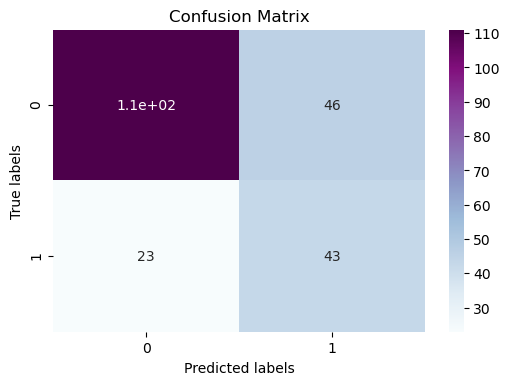

In [7]:
# A simple SVM 

model = SVC(kernel='linear') 
kf=KFold(n_splits=5)  # cross validation with Kfold
err2,score2=acc_model(model,X_train,y_train,X_test,y_test,kf)  

In [8]:

parameters ={'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf']}

### SVM with parameter optimization using grid search

grid_search = GridSearchCV( SVC(), 
                            parameters, 
                            cv=5,
                            scoring='accuracy',n_jobs=-1)
grid_result= grid_search.fit(X_train,y_train)
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score:  0.6916058803725733


69.05829596412556% of the test samples are corrrectly classified 


68.02021216496139% of the test samples are corrrectly classified with 5-Fold cross-validation 




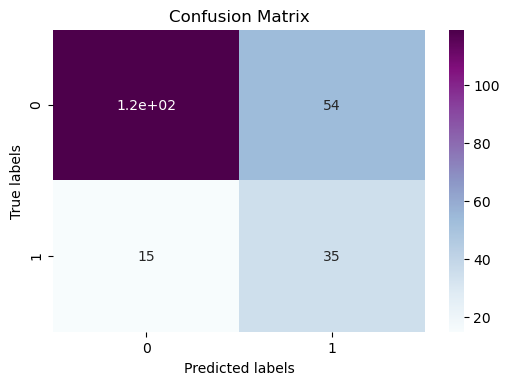

In [16]:

svmGridsearch=SVC(C=100, gamma= 0.001,kernel='rbf')
err3,score3=acc_model(svmGridsearch,X_train,y_train,X_test,y_test,kf)  

In [10]:
### SVM with parameter optimization using random search

random_search=RandomizedSearchCV(estimator = SVC(), 
                                 param_distributions=parameters,
                                 verbose=3, 
                                 n_jobs=-1,
                                 n_iter=50)
random_result = random_search.fit(X_train, y_train)
print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Score:  69.16058803725733
Best Params:  {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


69.05829596412556% of the test samples are corrrectly classified 


68.02021216496139% of the test samples are corrrectly classified with 5-Fold cross-validation 




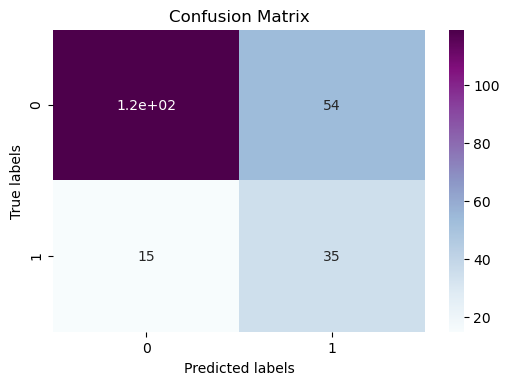

In [11]:
svmRandom=SVC(C=100, gamma= 0.001,kernel='rbf')
svmRandom.fit(X_train,y_train)
err4,score4=acc_model(svmRandom,X_train,y_train,X_test,y_test,kf) 

In [12]:
### SVM with parameter optimization using hyperopt

space = {"C": hp.choice("C", [0.1, 1, 10, 100, 1000]),
         "gamma": hp.choice("gamma", [1, 0.1, 0.01, 0.001, 0.0001]),
         "kernel": hp.choice("kernel", ['rbf']),}

# define objective function

def hyperparameter_tuning(params):
    model = SVC(**params)
    acc = cross_val_score(model, X_train, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}


In [13]:
# Initialize trials object
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space = space, 
            algo=tpe.suggest, 
            max_evals=50, 
            trials=trials)

print("Best: {}".format(best))

100%|██████████| 50/50 [00:40<00:00,  1.24trial/s, best loss: -0.6916058803725733]
Best: {'C': 3, 'gamma': 3, 'kernel': 0}


69.05829596412556% of the test samples are corrrectly classified 


68.02021216496139% of the test samples are corrrectly classified with 5-Fold cross-validation 




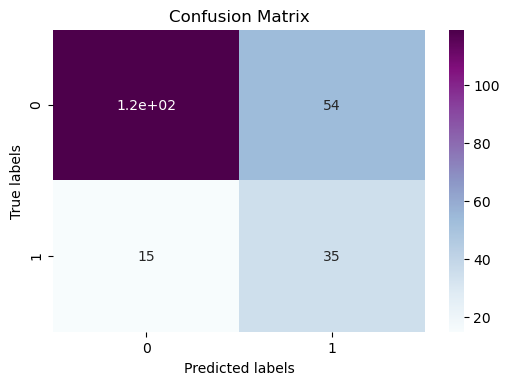

In [14]:
svmHyperopt = SVC(C=100,gamma=0.001,kernel='rbf')
svmHyperopt.fit(X_train,y_train)
err5,score5=acc_model(svmHyperopt,X_train,y_train,X_test,y_test,kf) 

In [17]:
## Results

print('..'*20)
print(model,':',score2)
print('..'*20)
print('Optimization by grid search\n',svmGridsearch,':',score3)
print('..'*20)
print('Optimization by random search\n',svmRandom,':',score4)
print('..'*20)
print('Optimization by hyperopt\n',svmHyperopt,':',score5)



........................................
SVC(kernel='linear') : 0.6813319942250958
........................................
Optimization by grid search
 SVC(C=100, gamma=0.001) : 0.6802021216496139
........................................
Optimization by random search
 SVC(C=100, gamma=0.001) : 0.6802021216496139
........................................
Optimization by hyperopt
 SVC(C=100, gamma=0.001) : 0.6802021216496139
